In [356]:
import os, sys 
import torch 
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import IPython.display as ipd
from argparse import Namespace
import torch.nn as nn 
import torch.nn.functional as F
import librosa
import argparse
import scipy 
from IPython.display import Audio
import numpy as np
from matplotlib.pyplot import cm
from tqdm import tqdm
import time
import comet_ml
from pprint import pprint
import pandas as pd

sys.path.append("../../")
from __config__ import *
import attentional_control.dnn.models.demucs as demucs_m
import attentional_control.dnn.models.dprnn as dprnn_m
import attentional_control.dnn.models.original_convtasnet as original_convtasnet_m
import attentional_control.dnn.models.eetp_tdcn as eetp_tdcn_m
import attentional_control.dnn.models.simplified_tasnet as two_step_m
import attentional_control.dnn.losses.sisdr as sisdr_lib
import attentional_control.utils.performance_results_parser as system_results_parser
system_local_results_path = '/home/thymios/projects/attentional_control/performance_outputs'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.empty_cache()

In [357]:
# Gather the experiment runs from the cometml experiments by calling the apiabs
project_api = comet_ml.API(api_key=API_KEY)
wsj_exp = 'wsj-all'
esc50_exp = 'esc50-all'
username_comet = 'etzinis'
exp_dict = {'wsj': {'exp_name': wsj_exp}, 'esc50': {'exp_name': esc50_exp}}

In [358]:
# Gather all appropriate data from the comet_ml experiments
val_metric_name = 'validate_SISDRi_mean'
performance_metric = 'sys.gpu.0.gpu_utilization'
results_dict = dict([(dataset, {}) for dataset in exp_dict.keys()])

for dataset in exp_dict.keys():
    this_experiments = project_api.get(username_comet, exp_dict[dataset]['exp_name'])
    for comet_exp in this_experiments:
        comet_id = comet_exp.id
        exp_data = project_api.get(username_comet, exp_dict[dataset]['exp_name'], comet_id)
        this_name = exp_data.name
        this_id = exp_data.id
        this_small_id = exp_data.id[:4]
        this_val_metric = exp_data.get_metrics(val_metric_name)

#         this_perf_metric = exp_data.get_metrics(performance_metric)
#         perf_metric_list = [float(x['metricValue']) for x in this_perf_metric]
#         print(this_name, np.array(perf_metric_list).mean())
        
        metric_list = [float(x['metricValue']) for x in this_val_metric]
        results_dict[dataset][this_id] = {'name': this_name, 'small_id': this_small_id,
                                          val_metric_name: np.array(metric_list)}


In [359]:
# Create the appropriate table
running_up_to_n_epochs = 120

for dataset in results_dict.keys():
    print(dataset)
    for id_c, data in results_dict[dataset].items():
        val_metric_data = data[val_metric_name][:running_up_to_n_epochs]
        try:
            print(data['name'], val_metric_data.max(),
                  np.argmax(val_metric_data), data[val_metric_name].shape)
        except Exception as e:
            print('Error with: {}'.format(data['name']))

wsj
mask_B4_N32 15.887482596369313 115 (205,)
zeromean_gradclip_latest 18.33099753342072 115 (210,)
deeper_upsampling4_L21_B256_H512_R16 16.747881400113304 56 (58,)
convtasnet 12.554024036436031 8 (10,)
Error with: convtasnet
demucs 11.103751420877874 37 (39,)
eetdcn_L21_H512_B128_X5_R16 17.0015798484087 116 (129,)
dil4_eetdcn_L21_B128_N512_X5_R16 17.02286933070421 119 (122,)
lr1e-4x0.98_demucs 12.117724207247297 114 (183,)
eetdcn_L21_H512_B128_X5_R8 15.371707861574988 114 (131,)
eetdcn_L21_H512_B128_X5_R4 13.393712637166182 116 (182,)
Error with: lr1e-4bsx0.98_dprnn
4bsx0.98_dprnn nan 92 (107,)
convtasnet 14.970607786082352 116 (160,)
eetdcn_L21_H512_B64_X5_R16 16.41985067941745 111 (118,)
esc50
spectra_theone_N256_L21 8.21740548042953 100 (122,)
zeromean_0xclass_R3_X8_LeakRelu 8.569666606501986 57 (230,)
dprnn 6.696489630598575 17 (18,)
zeromean_noclipgrad_x0.98_lr1e-4_depth6_ch64_demucs 7.234772518323114 100 (190,)
convtasnet 6.748257934606324 10 (11,)
demucs 6.487106286712612 30 (3

In [360]:
print_names_dict = {
    'Demucs': ['demucs'],
    'DPRNN': ['dprnn'],
    'ConvTasNet': ['convtasnet'],
    'Sudo rm -rf 1.0': ['eetdcn_L21_H512_B128_X5_R16', 'eetdcn_L21_B128_N512_X5_R16', 'sudormrf_R16'],
    'Sudo rm -rf 0.5': ['eetdcn_L21_H512_B128_X5_R8', 'eetdcn_L21_B128_N512_X5_R8', 'sudormrf_R8'],
    'Sudo rm -rf 0.25': ['eetdcn_L21_H512_B128_X5_R4', 'eetdcn_L21_B128_N512_X5_R4', 'sudormrf_R4'],
#     'EETDCN small': ['eetdcn', 'R8'],
    'Two-Step TDCN': ['spectra', 'mask', 'twostep']
}

In [361]:
# Gather the best perofrming experiments
def get_metric_data(results_dict, dataset='wsj', keywords=[],
                    keep_only='max'):
    possible_data = []
    for id_c, data in results_dict[dataset].items():
        for key in keywords:
            if key in data['name']:
                possible_data.append(data[val_metric_name])
                break
                
    if not possible_data:
        print('Error with keywords: {}'.format(keywords))
        return np.array([0., 0.])
    else:
        if keep_only == 'max':
            possible_data = [p for p in possible_data if len(p)>1]
            s_possible = sorted(possible_data, key=lambda x: x.max())[-1]
            return s_possible

In [362]:
for model_name, keywords in print_names_dict.items():
    for dataset in results_dict.keys():
        possible_data =  get_metric_data(results_dict, dataset=dataset, keywords=keywords, keep_only='max')
        print(model_name, dataset, possible_data.max())

Demucs wsj 12.537121573972206
Demucs esc50 7.3557785869694
DPRNN wsj nan
DPRNN esc50 7.1968155200884985
ConvTasNet wsj 15.22494290238619
ConvTasNet esc50 7.831291692034652
Sudo rm -rf 1.0 wsj 17.02286933070421
Sudo rm -rf 1.0 esc50 8.354060517715912
Sudo rm -rf 0.5 wsj 15.406825673523048
Sudo rm -rf 0.5 esc50 8.121545569056956
Sudo rm -rf 0.25 wsj 13.43899151417613
Sudo rm -rf 0.25 esc50 7.928667204977324
Two-Step TDCN wsj 16.224690874497416
Two-Step TDCN esc50 8.21740548042953


In [363]:
pprint(results_dict)

{'esc50': {'018694b9290545adb6d16b829290e757': {'name': 'dprnnx0.98',
                                                'small_id': '0186',
                                                'validate_SISDRi_mean': array([4.55955125, 5.24209183, 5.01115588, 5.14129433, 5.12950324,
       5.20693129, 6.05407427, 5.75256974, 6.11682202, 5.9279871 ,
       6.11876248, 5.56730955, 5.85795272, 6.38938233, 6.42075766,
       6.04506742, 6.50514009, 6.30047723, 5.90862814, 6.07508468,
       6.23650278, 6.35533269, 5.97077358, 6.57802659, 6.28761419,
       6.5067601 , 6.66147176, 5.2379692 , 6.16284695, 6.51460466,
       6.39943249, 6.08616729, 6.12073782, 5.79404217, 6.09602846,
       5.85252676, 5.71279339, 6.25299892, 6.48621638, 6.56674283,
       6.43512988, 6.49307915, 6.64896521, 6.5100883 , 6.13472503,
       6.5678068 , 6.51271898, 6.4981122 , 6.2798695 , 6.60862672,
       6.7274792 , 6.6543139 , 6.47026202, 6.69529423, 6.45219255,
       6.58831842, 6.68440953, 6.74115272, 6.7899634 

In [364]:
# Parse system results form local runs
system_results_dic = system_results_parser.gather_results_for_available_models(system_local_results_path)
# Update the final results dictionary for all models
final_dict = dict([(p, {}) for p in print_names_dict])
for model_name, keywords in print_names_dict.items():
    for dataset in results_dict.keys():
        possible_data =  get_metric_data(results_dict, dataset=dataset,
                                         keywords=keywords,
                                         keep_only='max')
        final_dict[model_name][dataset + ' SISDRi'] = possible_data
        
        # find the appropriate naming in the system results dictionary
        found = False
        for system_name, system_info in system_results_dic.items():
            for k in keywords:
                if k in system_name:
                    found=True
                    break
            if found:
                final_dict[model_name].update(system_info)
                break
                    
pprint(final_dict)

{'ConvTasNet': {'cpu': {'Backward CPU RAM (GB)': 0.711696,
                        'Forward CPU RAM (GB)': 0.647816,
                        'Forward GMACS': 5.134,
                        'Forward time (sec)': 0.897068440914154,
                        'Parameters (millions)': 5.051,
                        'batch_size': 1,
                        'device': 'cpu',
                        'input_samples': 8000,
                        'model_name': 'baseline_original_convtasnet'},
                'esc50 SISDRi': array([5.17934791, 5.57324969, 5.97506359, 5.67340949, 4.70989453,
       6.5093527 , 6.43340989, 5.92036668, 6.24799057, 6.11228021,
       6.33941921, 6.23962807, 6.69977096, 6.73068035, 6.18550558,
       6.6669951 , 6.66656465, 6.33960226, 6.35450869, 6.30512721,
       6.63860744, 6.49379648, 6.64913838, 6.80303602, 6.76331091,
       6.99788608, 7.01296167, 7.12961828, 7.02489934, 7.02459743,
       6.96642266, 7.06131034, 7.17256341, 7.03428335, 6.99721419,
       6.8630

In [373]:
# Insert the actual GFLOPs extracted from a sampling profiler
sampling_prof ={
    'Demucs': {'Forward GFLOPS': 3.43, 'Backward GFLOPS': 10.34},
    'DPRNN': {'Forward GFLOPS': 48.89, 'Backward GFLOPS': 48.90},
    'ConvTasNet': {'Forward GFLOPS': 5.23, 'Backward GFLOPS': 5.3},
    'Sudo rm -rf 1.0': {'Forward GFLOPS': 2.52, 'Backward GFLOPS': 2.56},
    'Sudo rm -rf 0.5': {'Forward GFLOPS': 1.54, 'Backward GFLOPS': 1.56},
    'Sudo rm -rf 0.25':{'Forward GFLOPS': 1.06, 'Backward GFLOPS': 1.07},
    'Two-Step TDCN':{'Forward GFLOPS': 7.09, 'Backward GFLOPS': 7.23},
}


# len32k_sampling_prof ={
#     'Demucs': 15.44 * 22.2,
#     'DPRNN': 190.61 * 72.65,
#     'ConvTasNet': 20.89 * 80.25,
#     'Sudo rm -rf 1.0': 10.12 * 167.39,
#     'Sudo rm -rf 0.5': 6.19 * 70.56,
#     'Sudo rm -rf 0.25': 4.24 * 38.55,
#     'Two-Step TDCN': 28.48 * 97.25,
# }

len32k_sampling_prof ={
    'Demucs': 15.44 ,
    'DPRNN': 190.61 ,
    'ConvTasNet': 20.89 ,
    'Sudo rm -rf 1.0': 10.12 ,
    'Sudo rm -rf 0.5': 6.19 ,
    'Sudo rm -rf 0.25': 4.24 ,
    'Two-Step TDCN': 28.48 ,
}

for model_name in final_dict:
    metric = 'Forward GFLOPS'
    final_dict[model_name]['cpu'][metric] = sampling_prof[model_name][metric]
    metric = 'Backward GFLOPS'
    final_dict[model_name]['cpu'][metric] = sampling_prof[model_name][metric]
    
    final_dict[model_name]['gpu']['32K_BS4_Total_PetaFLOPS'] = 4 * 5 * len32k_sampling_prof[model_name] / 10**3
    

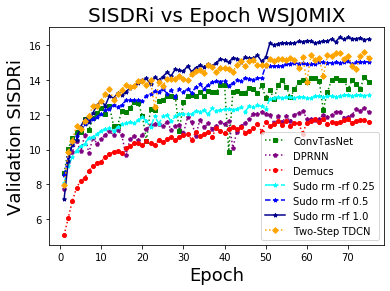

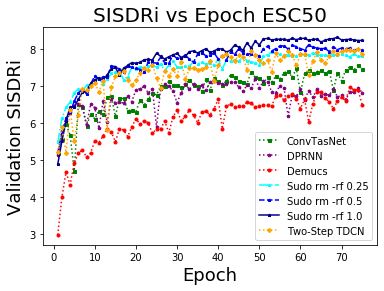

In [374]:
# Visualize loss history
# linestyles = [‘solid’ | ‘dashed’, ‘dashdot’, ‘dotted’ | 
#               (offset, on-off-dash-seq) | '-' | '--' | '-.' | ':' 
#               | 'None' | ' ' | '']
# markers: https://matplotlib.org/2.1.1/api/markers_api.html#module-matplotlib.markers
sorted_names = [n for n in sorted(final_dict.keys()) if n != 'DPRNN']
sorted_names = [n for n in sorted(final_dict.keys()) ]

until = 75
figure_dic = {
    'Demucs': {'color': 'red', 'linestyle': ':', 'marker': 'o'},
    'DPRNN': {'color': 'purple', 'linestyle': ':', 'marker': 'p'},
    'ConvTasNet': {'color': 'green', 'linestyle': ':', 'marker': 's'},
    'Sudo rm -rf 1.0': {'color': 'darkblue', 'linestyle': '-', 'marker': '*'},
    'Sudo rm -rf 0.5': {'color': 'blue', 'linestyle': '--', 'marker': '*'},
    'Sudo rm -rf 0.25': {'color': 'cyan', 'linestyle': '-.', 'marker': '*'},
    'Sudo rm -rf': {'color': 'darkblue', 'linestyle': '--', 'marker': '*'},
    'Two-Step TDCN': {'color': 'orange', 'linestyle': ':', 'marker': 'D'}
}

fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)
for idx, model_name in enumerate(sorted_names):
    data = final_dict[model_name]
    ys = data['wsj SISDRi'][:until]
    xs = np.arange(ys.shape[0]) + 1
    plt.plot(xs, ys,
             color=figure_dic[model_name]['color'],
             linestyle=figure_dic[model_name]['linestyle'],
             marker=figure_dic[model_name]['marker'],
#              markerfacecolor='blue',
             markersize=4)
plt.legend(sorted_names)
plt.title('SISDRi vs Epoch WSJ0MIX', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Validation SISDRi', fontsize=18)
plt.show();
# fig.savefig('test2png.png', dpi=100)

fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)
for idx, model_name in enumerate(sorted_names):
    data = final_dict[model_name]
    ys = data['esc50 SISDRi'][:until]
    xs = np.arange(ys.shape[0]) + 1
    plt.plot(xs, ys,
             color=figure_dic[model_name]['color'],
             linestyle=figure_dic[model_name]['linestyle'],
             marker=figure_dic[model_name]['marker'],
#              markerfacecolor='blue',
             markersize=3)
plt.legend(sorted_names)
plt.title('SISDRi vs Epoch ESC50', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Validation SISDRi', fontsize=18)
plt.show();
# fig.savefig('test2png.png', dpi=100)

ConvTasNet
13.083526425043742
30
DPRNN
9.868674088302999
3
Demucs
11.253769172489642
41
Two-Step TDCN
13.982345179532476
22
Sudo rm -rf 0.25
13.410181930204233
149
Sudo rm -rf 0.5
15.338608892487983
102
Sudo rm -rf 1.0
16.264845421227317
62


/home/thymios/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/thymios/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


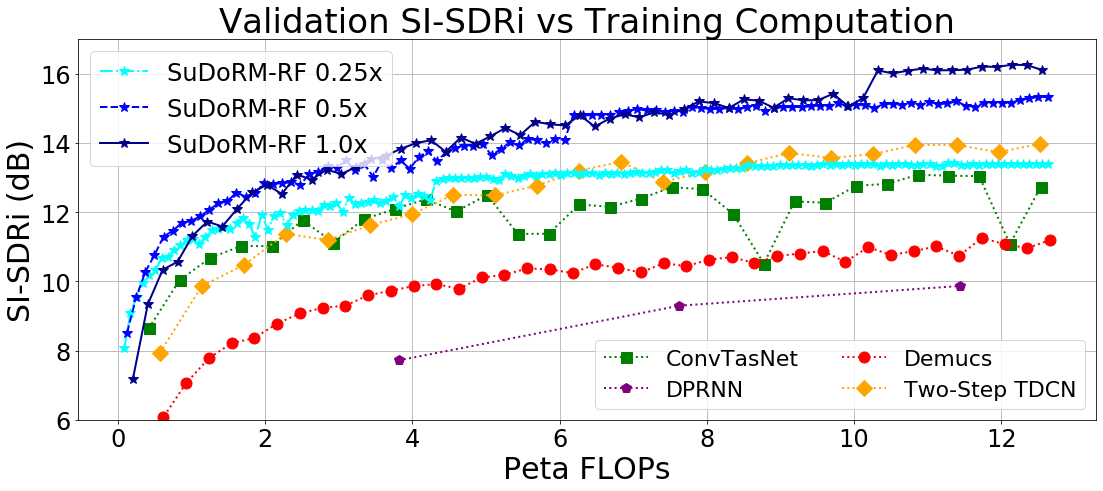

In [458]:
# Try to make the same plot as above but with GFLOPs as axis:
from_epoch = 5
until_epoch = 150
# find minimum floating point operations
max_flops = until_epoch * min([final_dict[m]['gpu']['32K_BS4_Total_PetaFLOPS'] for m in final_dict])
all_but_sudo = [m for m in sorted_names if not m.startswith('Sudo')]
sudo_models = [m for m in sorted_names if m.startswith('Sudo')]
sudo_models_map = dict([(m, 'SuDoRM-RF '+m.split()[3] + 'x') for m in sudo_models])

def crop_to_min_flops(xs, ys, max_x):
    new_xs, new_ys = [], []
    for i, (x, y) in enumerate(zip(xs, ys)):
        if x < max_x:
            new_xs.append(x)
            new_ys.append(y)
        else:
            break
    return new_xs, new_ys

fig = plt.gcf()
fig.set_size_inches(18.25, 7)

all_lines = []

for idx, model_name in enumerate(all_but_sudo + sudo_models):
    data = final_dict[model_name]
    ys = data['wsj SISDRi'][:until_epoch]
    
    xs = np.arange(ys.shape[0]) + 1
    # convert epochs to flops
    xs = xs * float(final_dict[model_name]['gpu']['32K_BS4_Total_PetaFLOPS'])
    xs, ys = crop_to_min_flops(xs, ys, max_flops)
    
    print(model_name)
    print(max(ys))
    print(len(ys))
    
    new_model_name = model_name
    try:
        new_model_name = sudo_models_map[model_name]
    except:
        pass
    
    this_line, = plt.plot(xs, ys,
             color=figure_dic[model_name]['color'],
             linestyle=figure_dic[model_name]['linestyle'],
             marker=figure_dic[model_name]['marker'],
#              markerfacecolor='blue',
             label=new_model_name,
             linewidth=2,
             markersize=11)
    all_lines.append(this_line)
# plt.legend(all_but_sudo + [sudo_models_map[m] for m in sudo_models], fontsize=22,
# #            bbox_to_anchor=(1, -0.15),
#            ncol=3, 
#           )
non_sudo_legend = plt.legend(all_but_sudo, fontsize=22,
#            bbox_to_anchor=(1, -0.15),
       ncol=2, loc='lower right', handles=all_lines[:-3] 
      )
plt.legend([sudo_models_map[m] for m in sudo_models], fontsize=24,
#            bbox_to_anchor=(1, -0.15),
       ncol=1, loc='upper left', handles=all_lines[-3:]
      )
plt.tick_params(axis='both', which='major', labelsize=24)
plt.gca().add_artist(non_sudo_legend)

plt.title('Validation SI-SDRi vs Training Computation', fontsize=34)
plt.xlabel('Peta FLOPs', fontsize=30)
plt.ylabel('SI-SDRi (dB)', fontsize=30)
plt.ylim([6, 17])
plt.grid()
# plt.show()
plt.savefig('cost_efficient_training.pdf', dpi=100, bbox_extra_artists=(non_sudo_legend,), bbox_inches='tight')


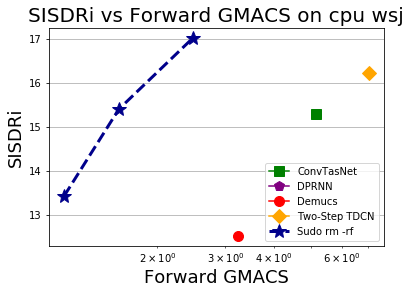

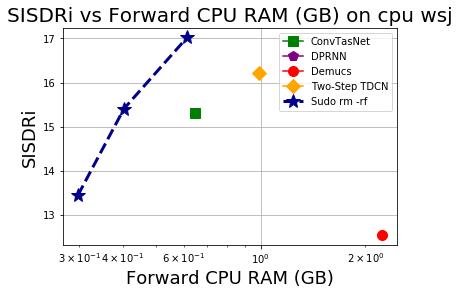

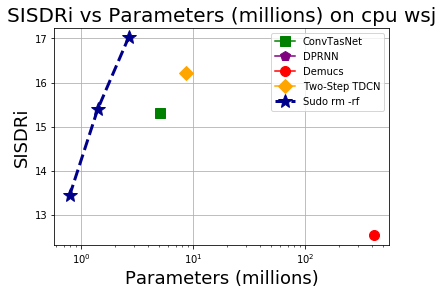

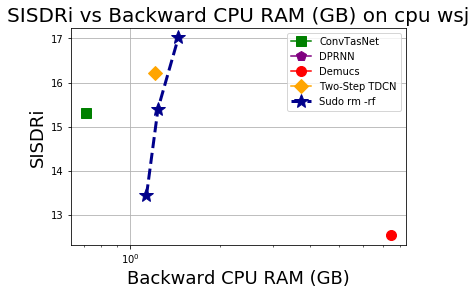

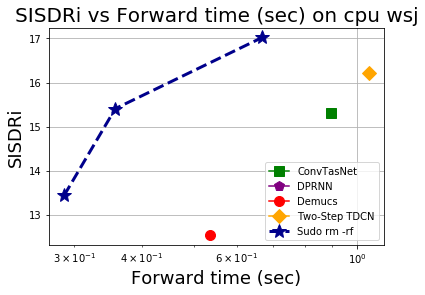

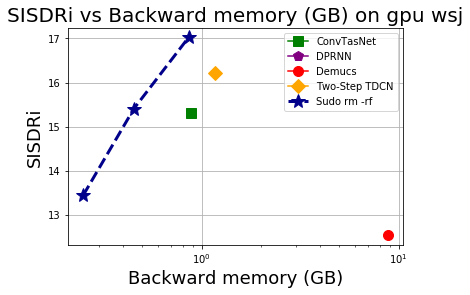

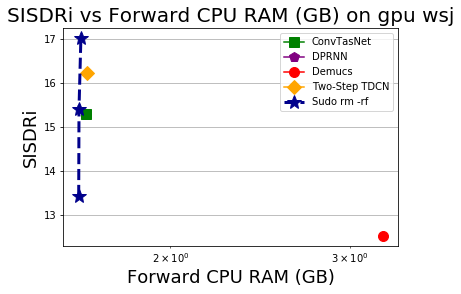

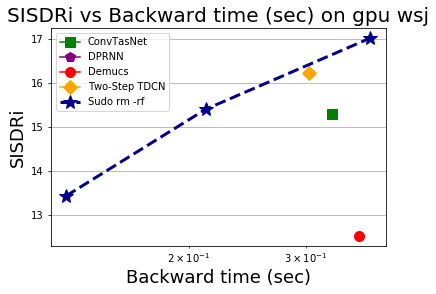

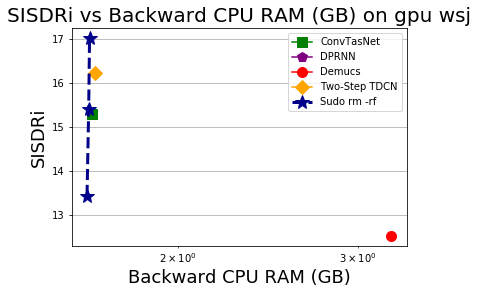

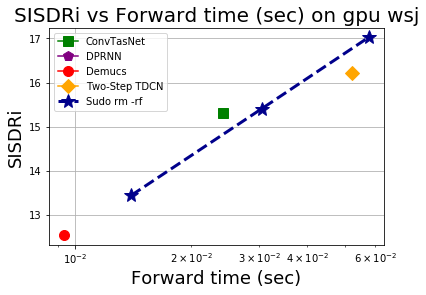

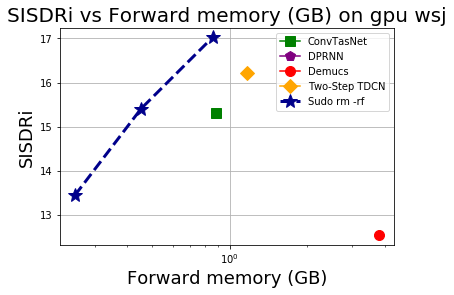

In [414]:
# Make some other plots to easily compare SISDRi performance vs other specs
sorted_names = [n for n in sorted(final_dict.keys())]

def assign_best_performance(performance, dataset, model_name):
    if dataset == 'esc50' and 'Two-Step' in model_name:
        return max(performance, 8.1)
    elif dataset == 'wsj' and 'DPRNN' in model_name:
        return max(performance, 18.8)
    elif dataset == 'wsj' and 'ConvTasNet' in model_name:
        return max(performance, 15.3)
    elif dataset == 'wsj' and 'Two-Step' in model_name:
        return max(performance, 16.1)
    return performance

    
def plot_sisdri_vs(final_dict, model_names, dataset, device,
                   performance_metric, figure_dic,
                   until=10000):
    all_but_sudo = [m for m in model_names if not m.startswith('Sudo')]
    sudo_models = [m for m in model_names if m.startswith('Sudo')]
    actual_metric_name = None 
    
    fig = plt.gcf()
    # fig.set_size_inches(18.5, 10.5)
    
    for idx, model_name in enumerate(all_but_sudo):
        data = final_dict[model_name]
        y = data[dataset + ' SISDRi'][:until].max()
        y = assign_best_performance(y, dataset, model_name)
        x = None
        for metric in data[device]:
            if performance_metric in metric:
                actual_metric_name = metric
                x = data[device][metric]
                break
        plt.semilogx(x, y,
                 color=figure_dic[model_name]['color'],
#                  linestyle=figure_dic[model_name]['linestyle'],
                 marker=figure_dic[model_name]['marker'],
    #              markerfacecolor='blue',
                 markersize=10)
    #     Gather all sudo best model performances
    sudo_results = []
    for idx, model_name in enumerate(sudo_models):
        data = final_dict[model_name]
        y = data[dataset + ' SISDRi'][:until].max()
        y = assign_best_performance(y, dataset, model_name)
        x = None
        for metric in data[device]:
            if performance_metric in metric:
                actual_metric_name = metric
                x = data[device][metric]
                sudo_results.append((x,y))
                break
            
    sudo_results = sorted(sudo_results, key=lambda x: x[0])
    plt.semilogx([x[0] for x in sudo_results], [x[1] for x in sudo_results],
              color=figure_dic['Sudo rm -rf']['color'],
              linestyle=figure_dic['Sudo rm -rf']['linestyle'],
              linewidth=3,
              marker=figure_dic['Sudo rm -rf']['marker'],
#               markerfacecolor='blue',
              markersize=15)
        
    plt.legend(all_but_sudo+['Sudo rm -rf'])
    plt.title('SISDRi vs {} {}'.format(actual_metric_name + ' on ' + device,
                                       dataset), fontsize=20)
    plt.xlabel(performance_metric, fontsize=18)
    plt.ylabel('SISDRi', fontsize=18)
    plt.grid()
    plt.show();
    # fig.savefig('test2png.png', dpi=100)
    
    
def plots_list_generator(dataset):
    return [{'dataset': dataset, 'device': 'cpu', 'metric': 'Forward GMACS'},
            {'dataset': dataset, 'device': 'cpu', 'metric': 'Forward CPU RAM (GB)'},
            {'dataset': dataset, 'device': 'cpu', 'metric': 'Parameters (millions)'},
            {'dataset': dataset, 'device': 'cpu', 'metric': 'Backward CPU RAM (GB)'},
            {'dataset': dataset, 'device': 'cpu', 'metric': 'Forward time (sec)'},

            {'dataset': dataset, 'device': 'gpu', 'metric': 'Backward memory (GB)'},
            {'dataset': dataset, 'device': 'gpu', 'metric': 'Forward CPU RAM (GB)'},
            {'dataset': dataset, 'device': 'gpu', 'metric': 'Backward time (sec)'},
            {'dataset': dataset, 'device': 'gpu', 'metric': 'Backward CPU RAM (GB)'},
            {'dataset': dataset, 'device': 'gpu', 'metric': 'Forward time (sec)'},
            {'dataset': dataset, 'device': 'gpu', 'metric': 'Forward memory (GB)'},
        #     {'dataset': 'wsj', 'device': 'cpu', 'metric': 'GMACS'},
        #     {'dataset': 'wsj', 'device': 'cpu', 'metric': 'GMACS'},
        ] 
    
dataset = 'wsj'
plots_to_generate = plots_list_generator(dataset)
for conf in plots_to_generate:
    plot_sisdri_vs(final_dict, sorted_names, conf['dataset'],
                   conf['device'], conf['metric'], figure_dic)

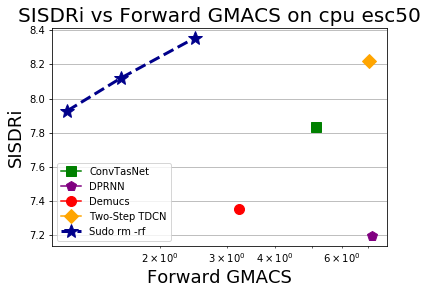

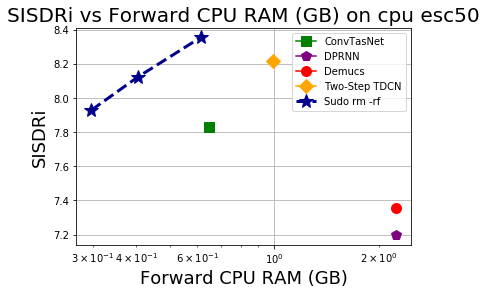

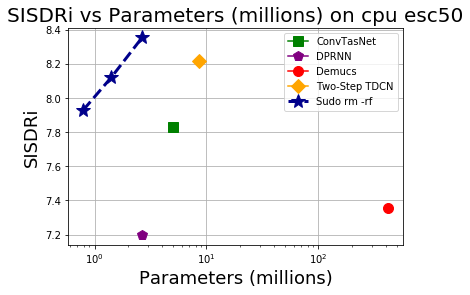

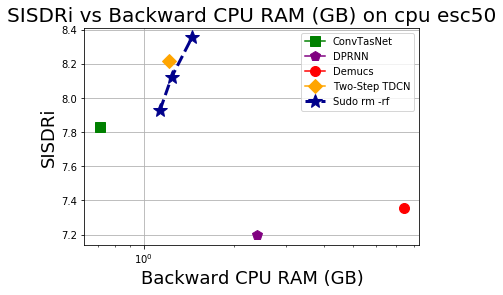

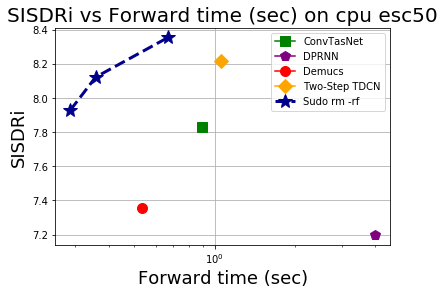

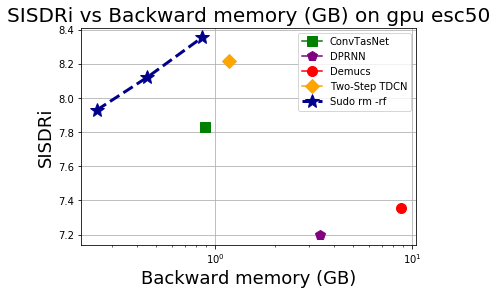

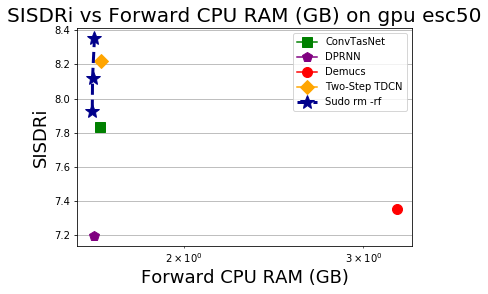

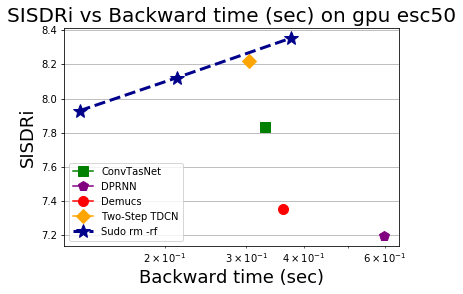

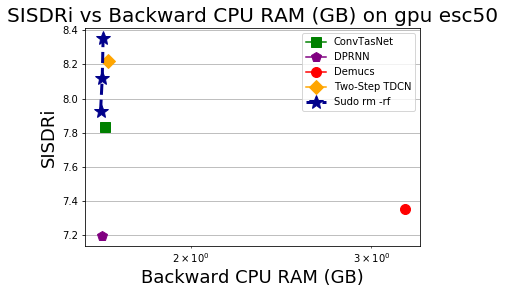

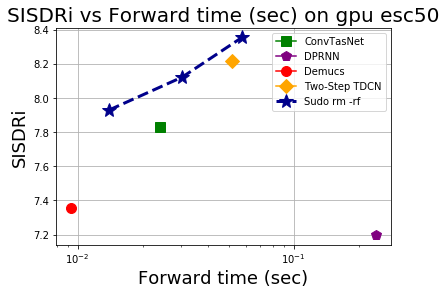

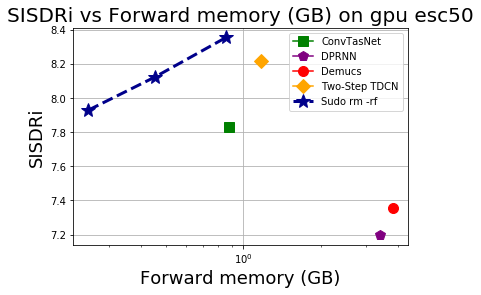

In [415]:
dataset = 'esc50'
plots_to_generate = plots_list_generator(dataset)
for conf in plots_to_generate:
    plot_sisdri_vs(final_dict, sorted_names, conf['dataset'],
                   conf['device'], conf['metric'], figure_dic)

['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
Legend
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']


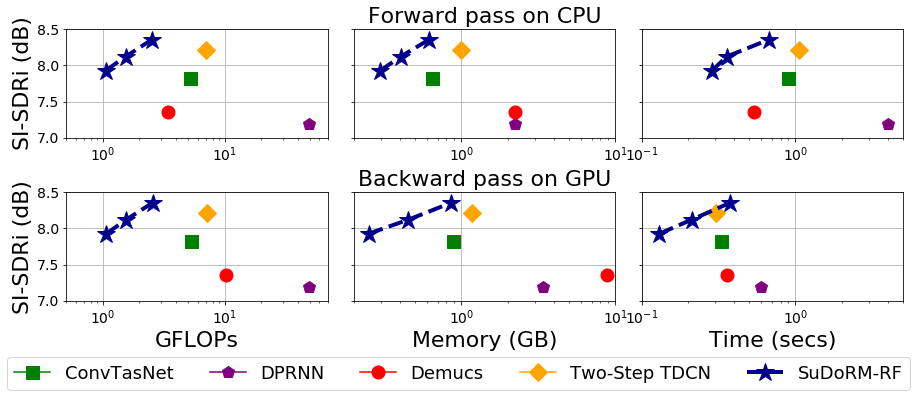

In [464]:
# Get the plots you need all in the same plot:
def subplot_sisdri_vs(axis, idx_i, idx_j, final_dict, model_names, dataset, device,
                      performance_metric, figure_dic,
                      until=10000, fontsize=22):
    all_ys, all_xs = [], []
    
    all_but_sudo = sorted([m for m in model_names if not m.startswith('Sudo')])
    print(all_but_sudo)
    sudo_models = [m for m in model_names if m.startswith('Sudo')]
    actual_metric_name = None 
    
    fig = plt.gcf()
    # fig.set_size_inches(18.5, 10.5)
    
    for idx, model_name in enumerate(all_but_sudo):
        data = final_dict[model_name]
        y = data[dataset + ' SISDRi'][:until].max()
        y = assign_best_performance(y, dataset, model_name)
        x = None
        for metric in data[device]:
            if performance_metric in metric:
                actual_metric_name = metric
                x = data[device][metric]
                break
        axis.semilogx(x, y,
                 color=figure_dic[model_name]['color'],
#                  linestyle=figure_dic[model_name]['linestyle'],
                 marker=figure_dic[model_name]['marker'],
    #              markerfacecolor='blue',
                 markersize=13)
        all_xs.append(x)
        all_ys.append(y)
    #     Gather all sudo best model performances
    sudo_results = []
    for idx, model_name in enumerate(sudo_models):
        data = final_dict[model_name]
        y = data[dataset + ' SISDRi'][:until].max()
        y = assign_best_performance(y, dataset, model_name)
        x = None
        for metric in data[device]:
            if performance_metric in metric:
                actual_metric_name = metric
                x = data[device][metric]
                sudo_results.append((x,y))
                all_xs.append(x)
                all_ys.append(y)
                break
            
    sudo_results = sorted(sudo_results, key=lambda x: x[0])
    axis.semilogx([x[0] for x in sudo_results], [x[1] for x in sudo_results],
              color=figure_dic['Sudo rm -rf']['color'],
              linestyle=figure_dic['Sudo rm -rf']['linestyle'],
              linewidth=4,
              marker=figure_dic['Sudo rm -rf']['marker'],
#               markerfacecolor='blue',
              markersize=19)
        
    lgd = None
    if i==1 and j ==1:
        axis.set_title('Backward pass on GPU', fontsize=fontsize)
        lgd = axis.legend(all_but_sudo+['SuDoRM-RF'], loc = 'lower center', fontsize=fontsize-4,
                          bbox_to_anchor=(0.4, -0.9), ncol=len(all_but_sudo)+1)
    if j==1 and i ==0:
        axis.set_title('Forward pass on CPU', fontsize=fontsize)
    if j==0:
        axis.set_ylabel('SI-SDRi (dB)', fontsize=fontsize)
#     else:
#         axis.yaxis.set_major_formatter(plt.NullFormatter())
    if 'Time' in performance_metric or 'time' in performance_metric:
        if i==1:
            axis.set_xlabel('Time (secs)', fontsize=fontsize)
        axis.set_xlim([0.1, 5])
    elif 'GB' in performance_metric:
        if i==1:
            axis.set_xlabel('Memory (GB)', fontsize=fontsize)
        axis.set_xlim([0.2, 10])
    elif 'Parameters' in performance_metric:
        axis.set_xlabel('Parameters (millions)', fontsize=fontsize)
    elif 'GMACS' in performance_metric:
        axis.set_xlabel('GMACS', fontsize=fontsize)
    elif 'GFLOPS' in performance_metric:
        if i==1:
            axis.set_xlabel('GFLOPs', fontsize=fontsize)
        axis.set_xlim([0.5, 70])
    axis.tick_params(axis='both', which='major', labelsize=14)
    axis.tick_params(axis='both', which='minor', labelsize=7)
#     axis.tight_layout()
#     axis.tick_params(which='minor', length=4, color='r')
# #     axis.set_xticks()
#     axis.xaxis.set_minor_formatter(plt.NullFormatter())


    
    axis.set_ylim([7.0, 8.5])

    axis.grid()
    return lgd
#     plt.show();
    # fig.savefig('test2png.png', dpi=100)


def plots_list_generator(dataset):
    return [[
#              {'dataset': dataset, 'device': 'cpu', 'metric': 'Forward GMACS'},
             {'dataset': dataset, 'device': 'cpu', 'metric': 'Forward GFLOPS'},
             {'dataset': dataset, 'device': 'cpu', 'metric': 'Forward CPU RAM (GB)'},
             {'dataset': dataset, 'device': 'cpu', 'metric': 'Forward time (sec)'}],
            
#              [{'dataset': dataset, 'device': 'cpu', 'metric': 'Parameters (millions)'},
             [{'dataset': dataset, 'device': 'cpu', 'metric': 'Backward GFLOPS'},
              {'dataset': dataset, 'device': 'gpu', 'metric': 'Backward memory (GB)'},
              {'dataset': dataset, 'device': 'gpu', 'metric': 'Backward time (sec)'},   
             ]]
    
conf = plots_list_generator('esc50')
    
fig, all_axis = plt.subplots(2, 3, figsize=(15,5),
#                              sharex=True,
                             sharey=True
                            )

this_lgd = None
for i in range(2):
    for j in range(3):
        lgd = subplot_sisdri_vs(all_axis[i,j], i, j, final_dict, sorted_names, conf[i][j]['dataset'],
                                conf[i][j]['device'], conf[i][j]['metric'], figure_dic)
        if lgd is not None:
            print(lgd)
            this_lgd = lgd
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.5)
plt.savefig('pareto.pdf', dpi=100, bbox_extra_artists=(this_lgd,), bbox_inches='tight')
# handles, labels = all_axis[1,1].get_legend_handles_labels()
# all_axis[1,1].legend(handles, labels)
# plt.legend( handles, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
#             bbox_transform = plt.gcf().transFigure )
#     fig.legend(labels, labels, loc = (0.5, 0), ncol=5 )

Print the WSJ plots
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']
['ConvTasNet', 'DPRNN', 'Demucs', 'Two-Step TDCN']


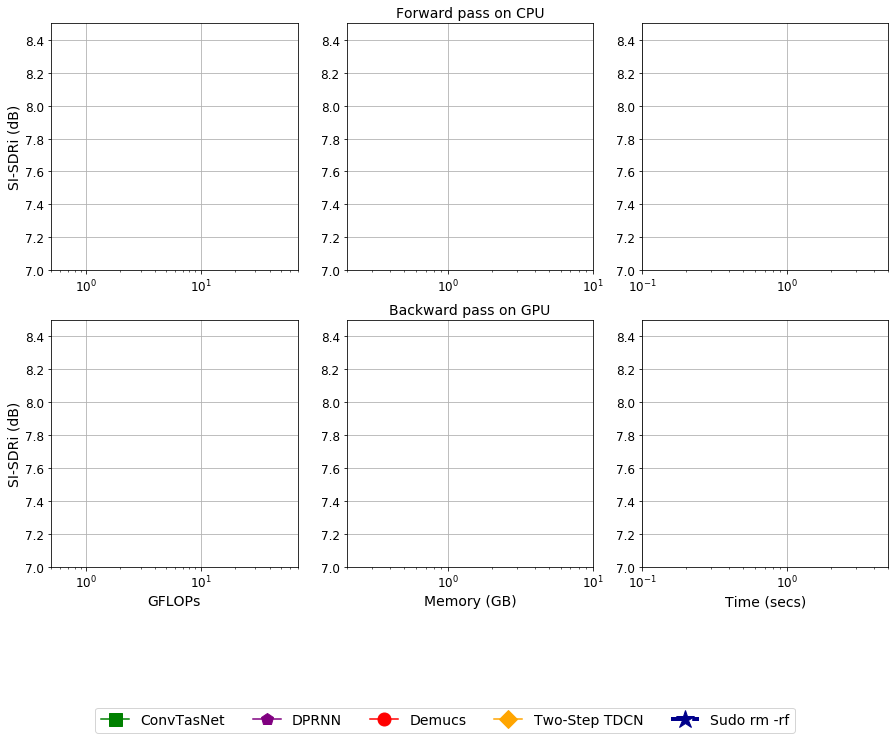

In [419]:
print('Print the WSJ plots')
conf = plots_list_generator('wsj')
    
fig, all_axis = plt.subplots(2, 3, figsize=(15,10))

for i in range(2):
    for j in range(3):
        subplot_sisdri_vs(all_axis[i,j], i, j, final_dict, sorted_names, conf[i][j]['dataset'],
                          conf[i][j]['device'], conf[i][j]['metric'], figure_dic)

In [279]:
# Generate the final results table directly in latex
def get_appropriate_dictionary_format(final_dict, until=100):
    new_dict = {}
    for model, data in final_dict.items():
        new_dict[model] = {}
        y = data['wsj SISDRi'][:until].max()
        y = assign_best_performance(y, 'wsj', model)
        new_dict[model]['wsj SISDRi'] = round(y, 2)
        y = data['esc50 SISDRi'][:until].max()
        y = assign_best_performance(y, 'esc50', model)
        new_dict[model]['esc50 SISDRi'] = round(y, 2)

    used_metrics = [
        {'device': 'cpu', 'metric': 'Forward GMACS'},
        {'device': 'cpu', 'metric': 'Forward CPU RAM (GB)'},
        {'device': 'cpu', 'metric': 'Parameters (millions)'},
        {'device': 'cpu', 'metric': 'Backward CPU RAM (GB)'},
        {'device': 'cpu', 'metric': 'Forward time (sec)'},

        {'device': 'gpu', 'metric': 'Backward memory (GB)'},
        {'device': 'gpu', 'metric': 'Forward CPU RAM (GB)'},
        {'device': 'gpu', 'metric': 'Backward time (sec)'},
        {'device': 'gpu', 'metric': 'Backward CPU RAM (GB)'},
        {'device': 'gpu', 'metric': 'Forward time (sec)'},
        {'device': 'gpu', 'metric': 'Forward memory (GB)'}]
    
    used_metrics = [
        {'device': 'cpu', 'metric': 'Parameters (millions)'},

#         {'device': 'cpu', 'metric': 'Forward GMACS'},
        {'device': 'cpu', 'metric': 'Forward GFLOPS'},
        {'device': 'cpu', 'metric': 'Backward GFLOPS'},

        {'device': 'cpu', 'metric': 'Forward CPU RAM (GB)'},
        {'device': 'gpu', 'metric': 'Backward memory (GB)'},

#         {'device': 'cpu', 'metric': 'Parameters (millions)'},
#         {'device': 'cpu', 'metric': 'Backward CPU RAM (GB)'},
        {'device': 'cpu', 'metric': 'Forward time (sec)'},

#         {'device': 'gpu', 'metric': 'Forward CPU RAM (GB)'},
        {'device': 'gpu', 'metric': 'Backward time (sec)'},
#         {'device': 'gpu', 'metric': 'Backward CPU RAM (GB)'},
#         {'device': 'gpu', 'metric': 'Forward time (sec)'},
#         {'device': 'gpu', 'metric': 'Forward memory (GB)'}
    ]
    
    for model, data in final_dict.items():
        for info_dic in used_metrics:
            device, metric = info_dic['device'], info_dic['metric']
            new_dict[model][metric + ' on ' + device] = round(data[device][metric], 2)
            
    return new_dict
        

In [280]:
final_table = pd.DataFrame.from_dict(get_appropriate_dictionary_format(final_dict, until=120), orient='index')
final_table

,wsj SISDRi,esc50 SISDRi,Parameters (millions) on cpu,Forward GFLOPS on cpu,Backward GFLOPS on cpu,Forward CPU RAM (GB) on cpu,Backward memory (GB) on gpu,Forward time (sec) on cpu,Backward time (sec) on gpu
Demucs,12.12,7.23,415.09,3.43,10.34,2.24,8.77,0.53,0.36
DPRNN,NaN,7.20,2.63,48.89,48.90,2.23,3.40,3.98,0.60
ConvTasNet,15.30,7.74,5.05,5.23,5.30,0.65,0.88,0.90,0.33
Sudo rm -rf 1.0,17.02,8.35,2.66,2.52,2.56,0.61,0.86,0.67,0.38
Sudo rm -rf 0.5,15.37,8.12,1.42,1.54,1.56,0.40,0.45,0.36,0.21
Sudo rm -rf 0.25,13.39,7.93,0.79,1.06,1.07,0.30,0.25,0.29,0.13
Two-Step TDCN,16.10,8.22,8.63,7.09,7.23,0.99,1.17,1.05,0.30


In [281]:
# final_table['wsj SISDRi', 'esc50 SISDRi', 'Forward GMACS', 'Forward CPU RAM (GB)']

In [282]:
stringos = pd.DataFrame.from_dict(get_appropriate_dictionary_format(final_dict, until=120),
                                  orient='index').to_latex()
for line in stringos.split('\n'):
    print(' '.join(line.split()))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} & wsj SISDRi & esc50 SISDRi & Parameters (millions) on cpu & Forward GFLOPS on cpu & Backward GFLOPS on cpu & Forward CPU RAM (GB) on cpu & Backward memory (GB) on gpu & Forward time (sec) on cpu & Backward time (sec) on gpu \\
\midrule
Demucs & 12.12 & 7.23 & 415.09 & 3.43 & 10.34 & 2.24 & 8.77 & 0.53 & 0.36 \\
DPRNN & NaN & 7.20 & 2.63 & 48.89 & 48.90 & 2.23 & 3.40 & 3.98 & 0.60 \\
ConvTasNet & 15.30 & 7.74 & 5.05 & 5.23 & 5.30 & 0.65 & 0.88 & 0.90 & 0.33 \\
Sudo rm -rf 1.0 & 17.02 & 8.35 & 2.66 & 2.52 & 2.56 & 0.61 & 0.86 & 0.67 & 0.38 \\
Sudo rm -rf 0.5 & 15.37 & 8.12 & 1.42 & 1.54 & 1.56 & 0.40 & 0.45 & 0.36 & 0.21 \\
Sudo rm -rf 0.25 & 13.39 & 7.93 & 0.79 & 1.06 & 1.07 & 0.30 & 0.25 & 0.29 & 0.13 \\
Two-Step TDCN & 16.10 & 8.22 & 8.63 & 7.09 & 7.23 & 0.99 & 1.17 & 1.05 & 0.30 \\
\bottomrule
\end{tabular}

